(assignment_1)=
# Assignment 1: Flow over an obstacle and channel flow

For this assignment you will do quantiative analysis for the flow over an obstacle (see {ref}`Assignment0`), and a qualitative analysis of rotating channel flow.

## Q1.1  continuity in a box

Using the simulated data set you produced in {ref}`Assignment0`:

Consider a single time step in the simulation.  Define a largish box in your model domain with the sides defined at two values of x, and the top defined by one value of z.  The bottom can be defined as the sea floor.  Show that the net flow into the box is close to zero. You can express the flow in terms of $m^2\,s^{-1}$ or $m^3\,s^{-1}$, but given that the flow is 2-D $m^2\,s^{-1}$ probably makes more sense.

```{hint}
Remember that you can do something like `ds = ds.sel(xt=slice(-50, 50), xu=slice(-50, 50))` to get the data just between -50 and +50 km.  And then repeat for the z direction to define your volume.  Check that your shape is correct by doing something like `display(ds)`.

For the vertical direction, w and u are offset from one another, with w on the bottom of the cell, so you want one more zw value than zt value in your final shape.  You can do this using either `sel` or `isel` and taking care with the limits.  For instance I ended up with dimensions `..., zt: 57, zw: 58, ...`.  If you are careful with this, your answer will be closer than if sloppy.  
```

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# use the matplotlib widget
%matplotlib widget

In [2]:
with xr.open_dataset('hydraulic.snapshot.nc') as ds:
    # bonus point: when using sel, w is located at the bottom of the u cells, so we want 
    # the zw at the top of the last zt cell.  We could also have done this with 
    # isel, perhaps more straight forwardly:
    ds = ds.isel(Time=-1, yu=1, yt=1).isel(zt=slice(0,40), 
                                          zw=slice(0, 41))
    ds = ds.sel(xt=slice(-50, 50), xu=slice(-50, 50))
    
    #display(ds)
    dsleft = ds.isel(xt=0, xu=0)
    transportl = dsleft.u.integrate(coord='zt')
    dsright = ds.isel(xt=-1, xu=-1)
    transportr = dsright.u.integrate(coord='zt')

    dstop = ds.isel(zt=-1, zw=-1)
    transportt = dstop.w.integrate(coord='xt') * 1000
    
    print(f'Flow in left {transportl:1.2f} m^2/s')
    print(f'Flow out right {transportr:1.2f}')
    print(f'Flow out top {transportt:1.2f}')
    print(f'Residual {(transportl - transportt - transportr):1.2f}')
    

Flow in left 7.28 m^2/s
Flow out right 10.57
Flow out top -3.39
Residual 0.09


## Q1.2 Calculate the transport in a "layer"

Consider all water colder than 12 degrees and plot its transport as a function of x along the channel.  Do this for one time step (though bonus grades for also doing it as a Hovmoller diagram).

```{hint}
You can make a version of the data set with u=0 for water warmer than 12 degrees by doing `ds['ucold'] = ds.u.where(ds.temp.values<=12, 0)`. The first argument is the condition, the second is the values to fill in `ds.ucold` if the condition is False. Don't forget to use `fillna` to take care of the NaN's in the data...
```

Discuss your result.  Is the transport constant?  If not, why do you think it is not constant?

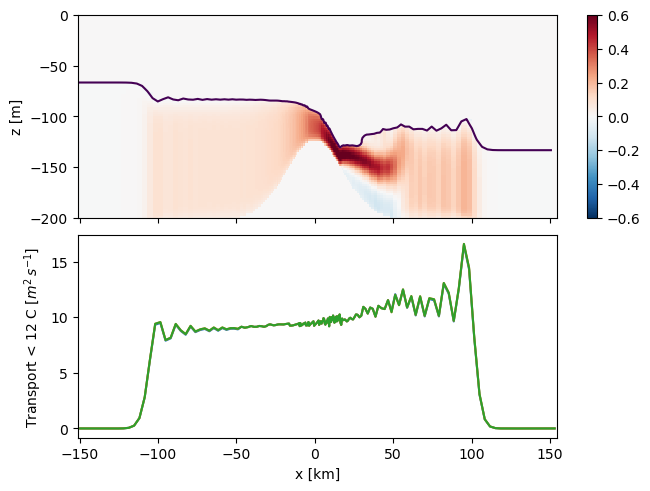

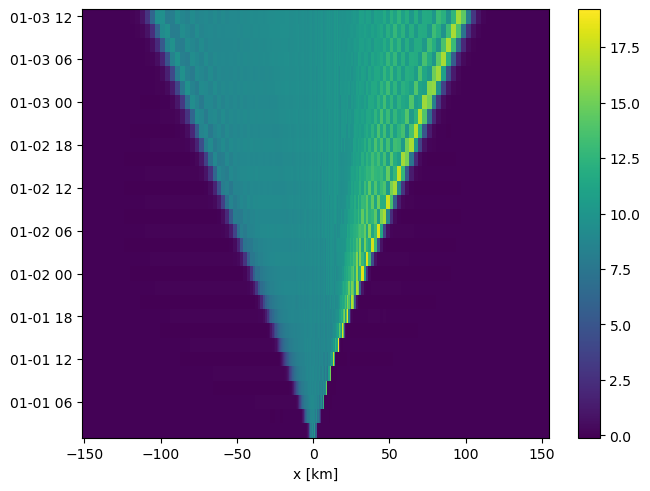

In [3]:
with xr.open_dataset('hydraulic.snapshot.nc') as ds:
    ds['Time'] = ds.Time + np.datetime64('2023-01-01')
    # bonus point: when using sel, w is located at the bottom of the u cells, so we want 
    # the zw at the top of the last zt cell.  We could also have done this with 
    # isel, perhaps more straight forwardly:
    ds = ds.isel(yu=-1, yt=-1)
    t0 = -1
    dz = ds.dzt.median()
    level = 12
    ds['ucold'] = ds.u.where(ds.temp.values<=level, 0).fillna(0)

    fig, axs = plt.subplots(2, 1, sharex=True, layout='constrained')
    pc = axs[0].pcolormesh(ds.xu, ds.zt, ds.ucold.isel(Time=t0), cmap='RdBu_r', clim=[-0.6, 0.6])
    fig.colorbar(pc, ax=axs[0])
    axs[0].contour(ds.xt, ds.zt, ds.temp.isel(Time=t0), levels=[level])
    axs[0].set_ylabel('z [m]')
    axs[1].plot(ds.xu, ds.ucold.integrate(coord='zt').isel(Time=t0))
    axs[1].plot(ds.xu, ds.ucold.sum(dim='zt').isel(Time=t0)*dz)
    axs[1].plot(ds.xu, np.sum(ds.ucold.isel(Time=t0), axis=0)*dz)
    axs[1].set_xlabel('x [km]')
    axs[1].set_ylabel('Transport < 12 C $[m^2\,s^{-1}]$')
    
    fig, ax = plt.subplots(layout='constrained')
    pc = ax.pcolormesh(ds.xu, ds.Time, ds.ucold.integrate(coord='zt'))
    ax.set_xlabel('x [km]')
    fig.colorbar(pc, ax=ax)

The flow in the layer is relatively constant to the left of the obstacle crest.  As the flow goes down the obstacle, there is mixing of water from above, and the volume transport increases somewhat.  Note that there are also some numerical instabilities as the resolution of the model degrades further from the centre of the domain.

## Q1.3 x-momentum budget (pointwise!)

The 2_D x-momentum budget for a non-rotating fluid is: 

$$ 
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + w\frac{\partial u}{\partial z} = - \frac{1}{\rho} \frac{\partial p}{\partial x}  + \nu_z \frac{\partial^2 u}{\partial z^2} + \nu_x \frac{\partial^2 u}{\partial x^2}
$$

In the model, $P$ is given by `ds.p_hydro + ds.psi`.  The vertical viscosity is $\nu_z=4\times10^{-4} \ \mathrm{m^2\,s^{-1}}$ and the horizontal is 
$\nu_x = 10\ \mathrm{m^2\,s^{-1}}$.

```{note}
In the real world viscosity doesn't depend on the direction.  In the model, the viscosity parameterizes unresolved turbulence.  Given that the horizontal scales are much larger than the vertical, the model works better if the horizontal viscsity is larger than the vertical.
```

For one timestep, calculate these terms at each point in the model and compare.

<xarray.DataArray 'w' (zt: 90, xu: 200)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan, -2.52786931e-08, -2.52601103e-08, ...,
         2.50701272e-08,  2.52210039e-08,  2.53068387e-08],
       [            nan, -4.21310797e-08, -4.21000079e-08, ...,
         4.17831339e-08,  4.20347753e-08,  4.21779710e-08],
       ...,
       [            nan, -1.46513050e-06, -1.46322426e-06, ...,
         1.46221542e-06,  1.46531675e-06,  1.46697889e-06],
       [            nan, -1.47956565e-06, -1.47769592e-06, ...,
         1.48089209e-06,  1.48411724e-06,  1.48594339e-06],
       [            nan, -1.49409789e-06, -1.49225961e-06, ...,
         1.49954839e-06,  1.50280678e-06,  1.50472793e-06]])
Coordinates:
    xt       (xu) float64 -151.3 -147.8 -144.4 -140.9 ... 144.4 147.8 151.3
    yt       float64 0.5
    yu       float64 1.0
    zw       (zt) float64 -197.8 -195.6 -193.3 -191.1 ... -4.44

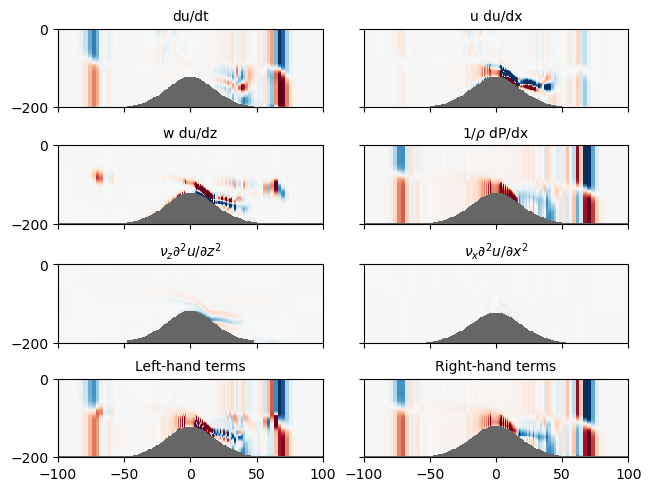

In [4]:
with xr.open_dataset('hydraulic.snapshot.nc') as ds:
    ds = ds.isel(yt=1, yu=1)
    dstime = ds.isel(Time=slice(19, 22))
    
    # on the u-grid:
    dudt = dstime.u.differentiate(coord='Time').isel(Time=1) * 1e9  # m/s^2
    
    ds = ds.isel(Time=20)
    
    # on the u-grid:
    ududx = ds.u * ds.u.differentiate(coord='xu') / 1000  # m/s^2
    
    # w du/dz: w is on the w grid.  du/dz could be calculated on the w grid, but we 
    # really want the data on the u grid.  So lets get w on the u grid:
    
    w_ugrid = ds.w.rolling(zw=2).mean().swap_dims({'zw':'zt'})
    w_ugrid = w_ugrid.rolling(xt=2).mean().swap_dims({'xt':'xu'})
    
    print(w_ugrid)
    wdudz = w_ugrid * ds.u.differentiate(coord='zt')
    
    # -dP/dx centered differentiation is on the T grid so we could do the rolling above, or just first difference and swap the dims:
    
    dpdx = -(ds.p_hydro + ds.psi).differentiate(coord='xt').rolling(zt=2).mean().swap_dims({'xt':'xu'}) / 1000
    
    # nu d^2u/dz^2
    vertdiff = 4e-4 * ds.u.differentiate(coord='zt').differentiate(coord='zt')
    
    # nu d^2u/dx^2
    horidiff = 10 * ds.u.differentiate(coord='xu').differentiate(coord='xu') / 1000 / 1000
        
    fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, layout='constrained', subplot_kw={'facecolor':'0.4'})
    vmin = -1e-5
    vmax = -vmin
    pcolorargs={'vmin':vmin, 'vmax':vmax, 'cmap':'RdBu_r'}
    axs[0, 0].pcolormesh(dudt.xu, dudt.zt, dudt, **pcolorargs)
    axs[0, 0].set_title('du/dt', fontsize='medium')
    axs[0, 1].pcolormesh(ududx.xu, ududx.zt, ududx, **pcolorargs)
    axs[0, 1].set_title('u du/dx', fontsize='medium')
    axs[1, 0].pcolormesh(wdudz.xu, ududx.zt, wdudz, **pcolorargs)
    axs[1, 0].set_title('w du/dz', fontsize='medium')
    axs[1, 1].pcolormesh(wdudz.xu, ududx.zt, dpdx, **pcolorargs)
    axs[1, 1].set_title(r'$1/\rho$ dP/dx', fontsize='medium')
    axs[2, 0].pcolormesh(wdudz.xu, ududx.zt, vertdiff, **pcolorargs)
    axs[2, 0].set_title(r'$\nu_z \partial^2 u/\partial z^2$', fontsize='medium')
    axs[2, 1].pcolormesh(wdudz.xu, ududx.zt, horidiff, **pcolorargs)
    axs[2, 1].set_title(r'$\nu_x \partial^2 u/\partial x^2$', fontsize='medium')

    lhs = dudt + ududx + wdudz
    rhs = dpdx + vertdiff + horidiff
    axs[3, 0].pcolormesh(wdudz.xu, ududx.zt, lhs, **pcolorargs)
    axs[3, 0].set_title('Left-hand terms', fontsize='medium')
    
    axs[3, 1].pcolormesh(wdudz.xu, ududx.zt, rhs, **pcolorargs)
    axs[3, 1].set_title('Right-hand terms', fontsize='medium')

    axs[0, 0].set_xlim([-100, 100])

    
    
    

## Q1.4 Describe

Describe the breakdown of terms in the x-momentum budget.  Focus in particular over obstacle, though the unsteady behaviour far from the obstacle is useful to think about as well.  
- Where is the flow almost in "steady state"? 
- What are the dominant terms in the momentum budget?  Write out an approximate balance that would explain most of the balance.
- Are the left- and right-hand terms _exactly_ in balance.  Any ideas why they are or are not.
- Explain the sense of the the largest terms in terms of the structure of the flow (eg does the structure of the terms make sense with respect to the flow?).

### Answer

- The flow is almost in steady state over the obstacle to the left of 20 km.  Downstream there is some unsteadiness, and far from the obstacle there is substantial unsteadiness at the leading edge of the waves proagating to the left and the right.

- The flow is pretty well described by $$ u \partial u / \partial x + w \partial u / \partial z \approx -(1/\rho) \partial P/\partial x$$  The veritcal viscosity term is not zero, but the horizontal viscosity is negligible. 

- The terms are not _exactly_ in balance because we have not calculated them exactly the way that the model calculates them.  

- The structure of the flow is mostly in the fast jet spilling over the obstacle.  This jet has some shear so that its speed is faster in the middle of the jet, and slow at the bottom and top.  
    - $u \partial u/\partial x$: u is > 0, so the sense of this term is largely given by du/dx. du/dx increases to the right through the jet until we emerge from the jet when it starts to drop, giving the red/blue stripe shown above.  
    - $w \partial u/\partial z$: $w<0$ in much of the jet, and $\partial u/\partial z<0$ except right at the bottom, so this term is mostly positive in the jet.
    - $-(1/\rho) \partial P/\partial x$: Pressure decreases to the right moving out of the jet as the water is less dense, so dP/dx <0 and this term is >0.  
    


## Q1.5 Internal versus external pressure

Similar to the above, compare the external pressure due to surface tilt (`psi`) to the internal pressure (`p_hydro`) at a given depth, preferably one that goes through the overflowing water.  

First, make a Hovmoller diagram of the surface pressure.  Try and describe what you see - any idea what causes this?

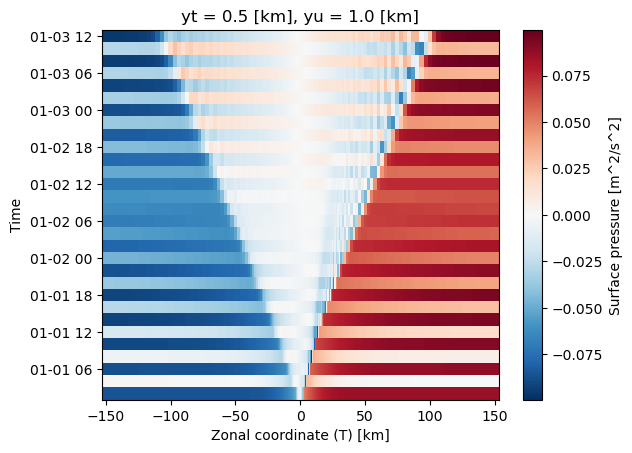

In [5]:
with xr.open_dataset('hydraulic.snapshot.nc') as ds:
    ds = ds.isel(yt=1, yu=1)
    ds['Time'] = ds.Time + np.datetime64('2023-01-01')
    fig, ax = plt.subplots()
    ds.psi.plot.pcolormesh(ax=ax)

There is pretty clearly a strong surface wave propagating back and forth on the surface.  This is not surprising, and is a fast wave that travels from end to end due to the initial conditions suddenly being released.  We call this a "start-up transient".  It will eventually die out, buit it is relatively small and there is not a lot to dissipate it.  

### Q1.5 continued

We need to do some smoothing to try and ignore the effect shown above, so average the data by 4 or 6 timesteps.  Then compare the internal to the surface pressure gradient at a depth that includes the overflow.

Compare and contrast the two pressure signals.  Does the pressure gradients make sense with respect to the direction that water flows?  How many centimeters of surface defelection would you expect to see for the given external pressure gradient?

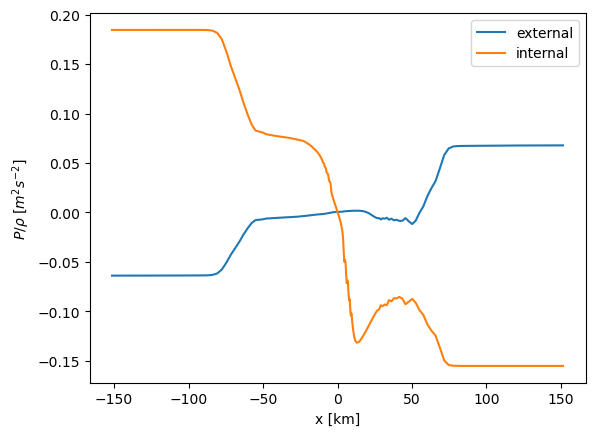

In [6]:
with xr.open_dataset('hydraulic.snapshot.nc') as ds:
    ds = ds.isel(yt=1, yu=1)
    ds = ds.isel(Time=slice(16, 22)).mean(dim='Time').sel(zt=-120, method='nearest')
    fig, ax = plt.subplots()
    ax.plot(ds.xt, ds.psi, label='external')
    ax.plot(ds.xt, ds.p_hydro-ds.p_hydro.sel(xt=0, method='nearest'), label='internal')
    ax.set_xlabel('x [km]')
    ax.set_ylabel(r'$P / \rho\ [m^2 s^{-2}]$')
    ax.legend()

The internal pressure is high on the right and drops quickly over the obstacle.  The surface pressure gradient is the opposite, and this drives the surface flow from the righthand basin to the left. 

## Q2: Channel flow Qualitative

In this simulation, we have a 50-m deep channel with quite steep sides 20 km apart in the y-direction.  The flow starts at rest when a wind stress of $\tau=0.2\,\mathrm{N\,m^{-2}}$ is applied in the positive x direction at time = 0.  This is called a spin-up problem.  We will do two simulations, one with rotation $f=10^{-4}\ \mathrm{rad\, s^{-1}}$ and the other without.

Note that this problem has no variability in the x direction (though there is definitely x-direction velocities!), so we don't use much resolution in the x direction.

Run [channelnof.py](./channelnof.py) and [channelfplane.py](./channelfplane.py) and plot the outputs:

- plot some represntative time steps of the channel crosssections (y versus z) for each run.
- choose a time step at the end of the simulation and one location and plot u on the x-axis and v on the y-axis with a dot for each depth.  This is called a "hodogram".
- what are the differences between the solution with rotation ansd the solution without rotation?

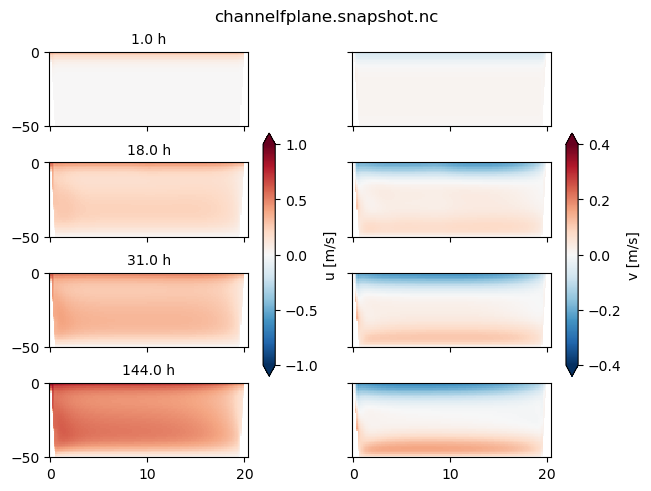

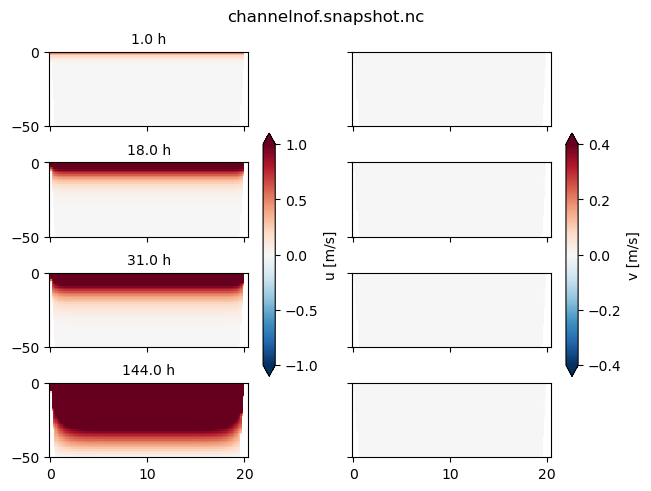

In [7]:
for todo in ['channelfplane.snapshot.nc', 'channelnof.snapshot.nc']:
    with xr.open_dataset(todo) as ds0:
        ds0 = ds0.isel(xt=0, xu=0)
        fig, axs = plt.subplots(4, 2, layout='constrained', sharex=True, sharey=True)
        for nn, td in enumerate([1, 17, 30, -1]):
            ds = ds0.isel(Time=td)
            pcu = axs[nn, 0].pcolormesh(ds.yt, ds.zt, ds.u, vmin=-1, vmax=1, cmap='RdBu_r')
            pcv = axs[nn, 1].pcolormesh(ds.yu, ds.zt, ds.v, vmin=-0.4,vmax=0.4, cmap='RdBu_r')
            axs[nn, 0].set_title(f'{np.floor(ds.Time.astype("float").values/1e9/3600)} h', fontsize='medium')
        fig.colorbar(pcu, ax=axs[:,0], shrink=0.6, extend='both', label='u [m/s]')
        fig.colorbar(pcv, ax=axs[:,1], shrink=0.6, extend='both', label='v [m/s]')
        fig.suptitle(todo)

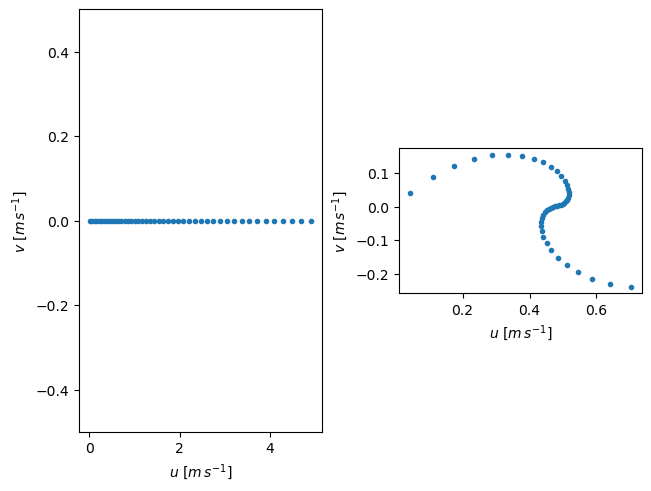

In [8]:
fig, axs = plt.subplots(1, 2, layout='constrained')
for nn, todo in enumerate(['channelnof.snapshot.nc', 'channelfplane.snapshot.nc']):
    with xr.open_dataset(todo) as ds:
        ds = ds.isel(xt=0, xu=0, Time=-1).sel(yt=10, yu=10, method='nearest')
        ax=axs[nn]
        ax.plot(ds.u, ds.v, '.')
        if nn==1:
            ax.set_aspect(1)
        else:
            ax.set_ylim(-0.5, 0.5)
        ax.set_xlabel('$u\ [m\,s^{-1}]$')
        ax.set_ylabel('$v\ [m\,s^{-1}]$')


For the non-rotating case, the velocity moves downwind, and continues to accelerate.  Momentum diffuses down until eventually it can dissipate near the sea floor.  No velocity develops in the cross-wind (y) direction.

Fo the rotating case, the water moves downwind, but there is also a flow to the right of the wind, cross channel.  This layer deepens, but maxes out at about 10-m deep.  In the interior there is a relatively constant flow with $v \approx=0$.  At the bottom, a flow develops that is to the right of the bottom stress.  In steady state this near-bottom flow balances the near surface flow. 

The hodograph shows the surface velocity is 45 degrees to the right of the wind stress.  
